In [1]:
#import packages
import pandas as pd
import numpy as np
import sqlite3
# import matplotlib
import matplotlib.pyplot as plt
# import Kmeans from sklearn
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from kneed import KneeLocator
import seaborn as sns
import random

In [2]:
df_bank =pd.read_csv('scaled_bank_data.csv', index_col=None)
df_unscaled =pd.read_csv('banking_data.csv', index_col=None)

In [3]:
# Droping the first column of unscaled data 
df_unscaled = df_unscaled.loc[:, ~df_unscaled.columns.str.contains('^Unnamed')]
df_unscaled

income  credit_debt  balance_saved  spending_total  count_total
0     26150         0.00           0.00        0.000000          0.0
1      6605      1548.23          12.89     -302.591291         65.0
2     18548       286.69         122.54     -182.923000         72.0
3     47668         0.00         609.33     -282.610746         77.0
4     44554        68.68         254.02     -488.632589         76.0
..      ...          ...            ...             ...          ...
742   14795         0.00           0.00      -91.891154         26.0
743   26387      1300.00          96.25     -198.251895         29.0
744   61300      9200.00           0.00     -468.355666         94.0
745   15100      1785.97           0.00     -198.167579        135.0
746   17875      1000.00           0.00     -209.040862        112.0

[747 rows x 5 columns]

In [4]:
# Making Df unscaled for a positive spending_total
df_mod = df_unscaled.copy()
df_mod['spending_total'] = abs(df_mod['spending_total'])
df_mod

income  credit_debt  balance_saved  spending_total  count_total
0     26150         0.00           0.00        0.000000          0.0
1      6605      1548.23          12.89      302.591291         65.0
2     18548       286.69         122.54      182.923000         72.0
3     47668         0.00         609.33      282.610746         77.0
4     44554        68.68         254.02      488.632589         76.0
..      ...          ...            ...             ...          ...
742   14795         0.00           0.00       91.891154         26.0
743   26387      1300.00          96.25      198.251895         29.0
744   61300      9200.00           0.00      468.355666         94.0
745   15100      1785.97           0.00      198.167579        135.0
746   17875      1000.00           0.00      209.040862        112.0

[747 rows x 5 columns]

In [5]:
# scaling the data using minmaxscalar
scaler = MinMaxScaler()
scaled_minmax = scaler.fit_transform(df_mod)

# Scaling the Data & finding number of clusters to use

In [6]:
# finding the elbow plot, for appropriate number of clusters
def plot_distortion(X,max_clusters = 10):
    # this is for calculating distortions
    distortions = []
    for i in range(1, max_clusters +1):
        km = KMeans(n_clusters=i,
                    init='k-means++',
                    n_init=10,
                    random_state=0)
        km.fit(X)
        distortions.append(km.inertia_)

    #this is for determining elbow point
    kl = KneeLocator(range(1, 11), distortions, curve="convex", direction="decreasing")
    print(f'the elbow point is {kl.elbow}')
    plt.style.use('fivethirtyeight')
    plt.plot(range(1,max_clusters +1), distortions, marker='o', color='black')
    plt.title('Elbow plot - Banking Behavior')
    plt.xlabel('Number of clusters')
    plt.ylabel('Distortion')
    plt.show() 


C:\Anaconda\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


the elbow point is 3


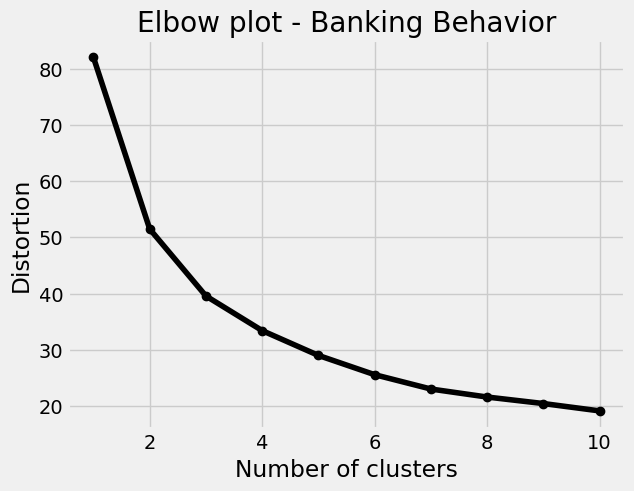

In [7]:
plot_distortion(scaled_minmax)

Here, we chose the min_max scaled data, with an n-cluster of three, because the radarplot will be easier to plot wit this min-max scale.

Now that we have the number of clusters to use, lets **calculate the kmeans using scikitlearn**

In [8]:
#Change the seed if you want different results
kmeans = KMeans(
# randomly choose rows or (samples)
init="random",
# how many clusters, 3, which we determined from the minmax scalar
n_clusters=3,
#number of times to run it
n_init=10,
# iterations per run
max_iter=300
)

In [9]:
#lets fit and predict the data 
y_km = kmeans.fit_predict(scaled_minmax)

# Doing visualizations to check out the data

In [10]:
#this is the modified dataframe that has positive as the spending total, you may also do the visualizations with negative, but positive makes more sense
df_mod 

income  credit_debt  balance_saved  spending_total  count_total
0     26150         0.00           0.00        0.000000          0.0
1      6605      1548.23          12.89      302.591291         65.0
2     18548       286.69         122.54      182.923000         72.0
3     47668         0.00         609.33      282.610746         77.0
4     44554        68.68         254.02      488.632589         76.0
..      ...          ...            ...             ...          ...
742   14795         0.00           0.00       91.891154         26.0
743   26387      1300.00          96.25      198.251895         29.0
744   61300      9200.00           0.00      468.355666         94.0
745   15100      1785.97           0.00      198.167579        135.0
746   17875      1000.00           0.00      209.040862        112.0

[747 rows x 5 columns]

In [11]:
#First visualize the raw data, to see how everything is grouped.
df = df_mod
g = sns.pairplot(df)
g.fig.suptitle("Pair plot comparing all features", y = 1.02)

Text(0.5, 1.02, 'Pair plot comparing all features')

From the looks of it, income seems to be correlated with most things. especially spending_total
count_total can be seen as how often they spend money. 

* The more income they have, the more people tend to spend
* everyone spends as often as they like, regardless of how much they saved
* people that have more income, tend to spend more often



In [12]:
plt.figure(figsize = (12,9))
plt.scatter(df_mod.iloc[:,1], df_mod.iloc[:,4])
plt.xlabel('Income in $')
plt.ylabel('Spending Totals in $')
plt.title('Visualization of Income & Spending total')

Text(0.5, 1.0, 'Visualization of Income & Spending total')

In [13]:
# plotting this heat map 
corr = df_mod.corr()
mask = np.zeros_like(corr, dtype= bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(12, 12))
sns.heatmap(
    corr,          # The data to plot
    mask=mask,     # Mask some cells
    annot=True,    # Should the values be plotted in the cells?
    vmax= 1,       # The maximum value of the legend. All higher vals will be same color
    vmin= -1,      # The minimum value of the legend. All lower vals will be same color
    center=0,      # The center value of the legend. With divergent cmap, where white is
    square=True,   # Force cells to be square
    linewidths=.5, # Width of lines that divide cells
    cbar_kws={"shrink": .5}  # Extra kwargs for the legend; in this case, shrink by 50%
)
ax.set_title('Heatmap of correlation between different banking features');

# Radar Plot


# Plotting kmeans, after doing PCA  

In [14]:
# import modules needed for PCA and visualization, Don't forget about the ones at the top
from sklearn.decomposition import PCA
import plotly.express as px

In [15]:
# convert data set from multidimensions to 2d (ONLY RUN THIS ONCE)
pca = PCA(n_components=2)
data = pca.fit_transform(scaled_minmax)

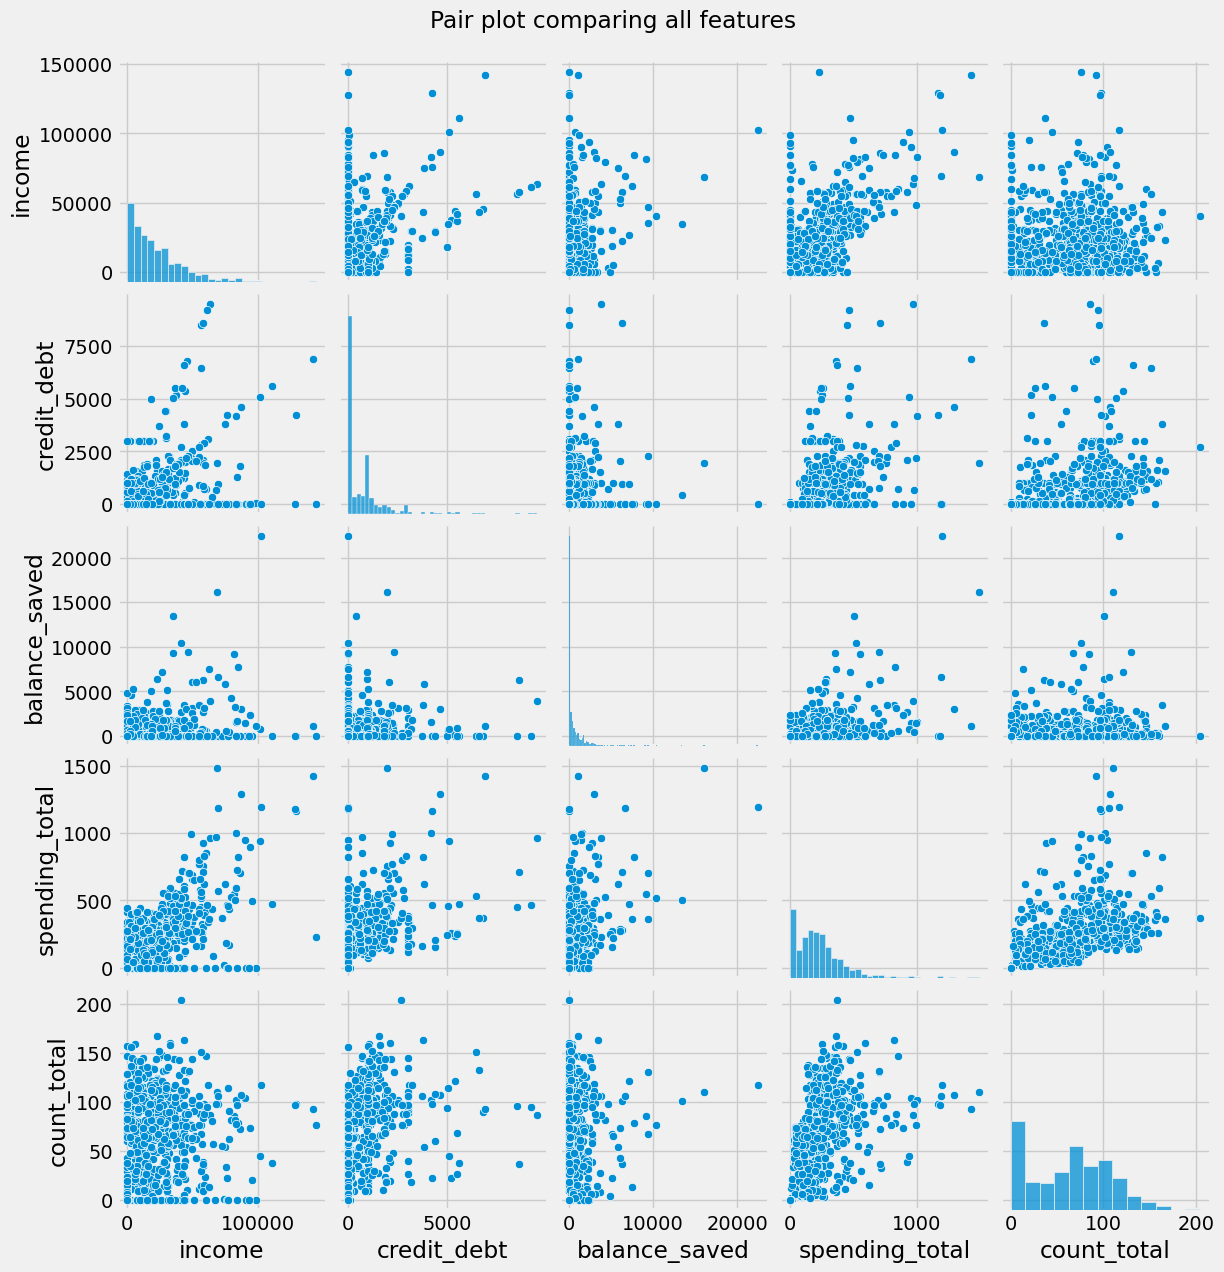

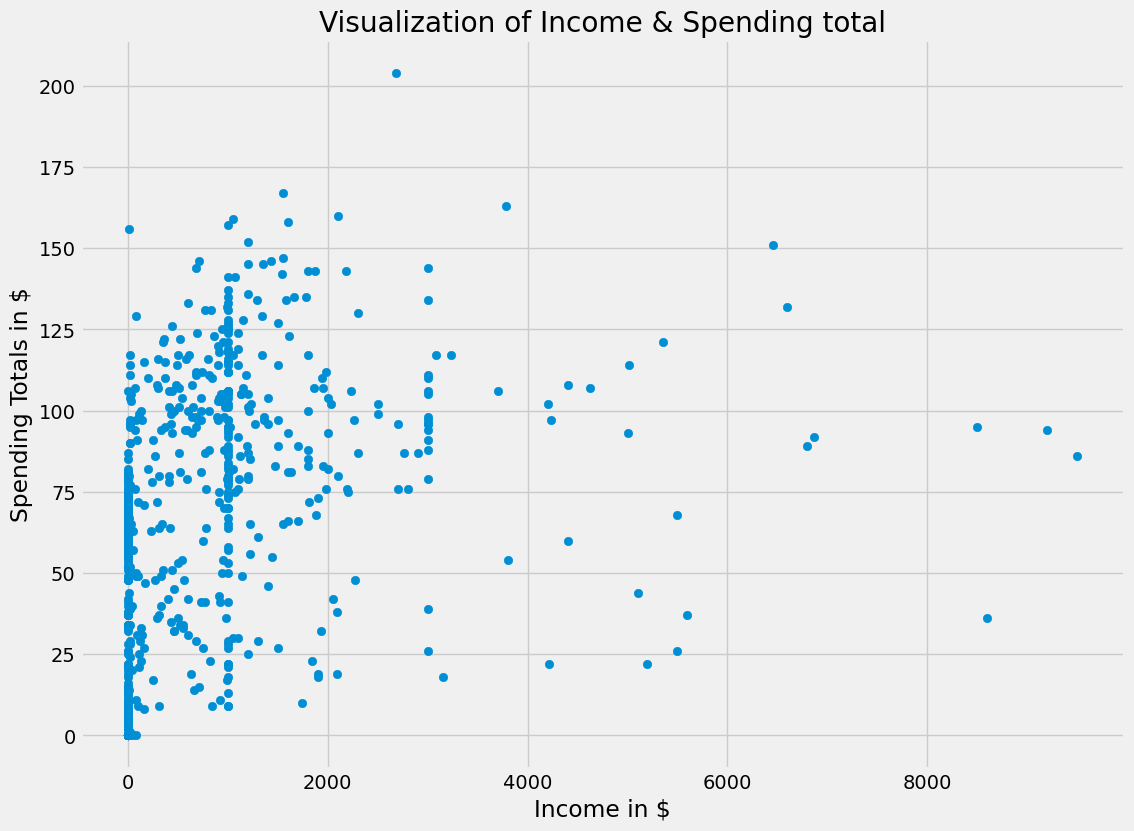

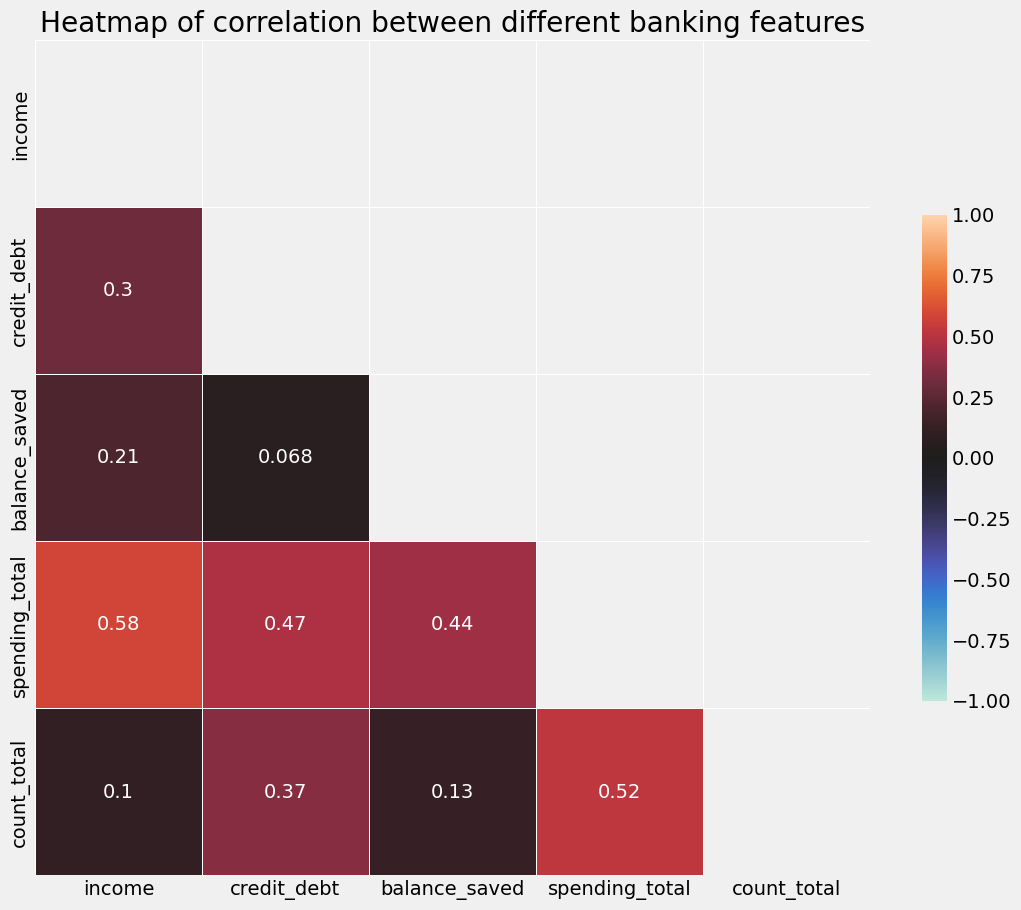

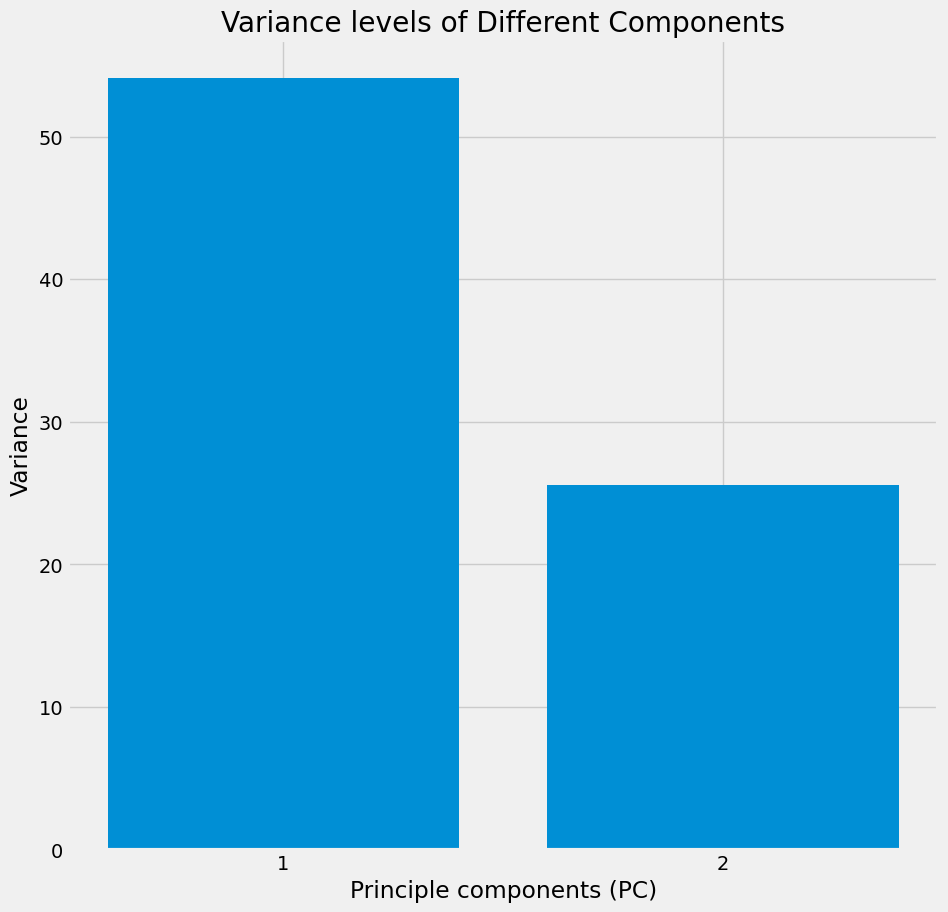

[54.1 25.6]


In [16]:
#plot the variance of the components
plt.figure(figsize=(10,10))
var = np.round(pca.explained_variance_ratio_*100, decimals = 1)
lbls = [str(x) for x in range(1,len(var)+1)]
plt.bar(x=range(1,len(var)+1), height = var, tick_label = lbls)
plt.ylabel('Variance')
plt.xlabel('Principle components (PC)')
plt.title('Variance levels of Different Components')
plt.show()
print(var)

In [17]:
#Define a function to plot the cluster
def plot_clusters(X,y_res, plt_cluster_centers = False):
    X_centroids = []
    Y_centroids = []

    for cluster in set(y_res):
        x = X[y_res == cluster,0]
        y = X[y_res == cluster,1]
        X_centroids.append(np.mean(x))
        Y_centroids.append(np.mean(y))

        plt.scatter(x,
                    y,
                    s=50,
                    marker='s',
                    label=f'cluster {cluster}')

    if plt_cluster_centers:
        plt.scatter(X_centroids,
                    Y_centroids,
                    marker='*',
                    c='red',
                    s=250,
                    label='centroids')
    plt.title('PC clusters- Banking Behavior with Income')
    plt.xlabel('PC-2')
    plt.ylabel('PC-1')
   
    plt.legend(loc='upper right', bbox_to_anchor=(1.1, 1.05))
    plt.grid()
    plt.show()

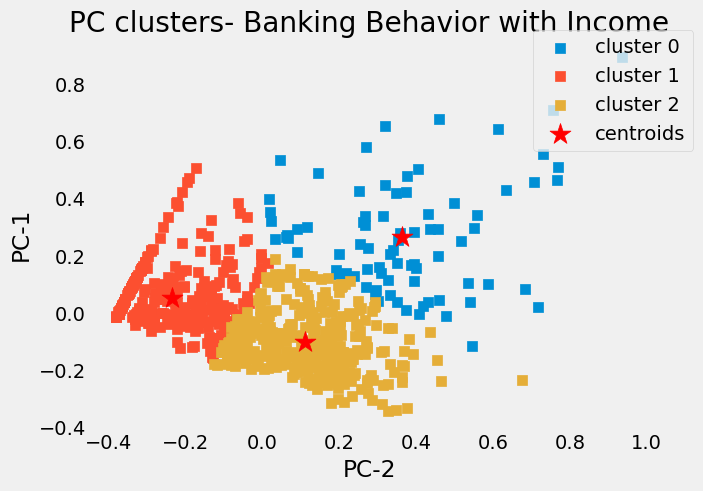

In [18]:
# Plot the clusters
plot_clusters(data,y_km,plt_cluster_centers = True)

In [19]:
# Setting up radar plot, need the groups, get this from kmeans (there are 3 groups here)
df_km = pd.DataFrame(y_km)
df_km = df_km.rename(columns = {0:'Groups'})

In [20]:
# set up dataframes with the data (this will be the radius for each value)
scaled = pd.DataFrame(scaled_minmax, columns=df_mod.columns)
scaled

income  credit_debt  balance_saved  spending_total  count_total
0    0.181399     0.000000       0.000000        0.000000     0.000000
1    0.045818     0.162972       0.000575        0.203771     0.318627
2    0.128665     0.030178       0.005463        0.123184     0.352941
3    0.330667     0.000000       0.027162        0.190316     0.377451
4    0.309066     0.007229       0.011324        0.329055     0.372549
..        ...          ...            ...             ...          ...
742  0.102631     0.000000       0.000000        0.061881     0.127451
743  0.183043     0.136842       0.004291        0.133507     0.142157
744  0.425231     0.968421       0.000000        0.315400     0.460784
745  0.104747     0.187997       0.000000        0.133450     0.661765
746  0.123997     0.105263       0.000000        0.140772     0.549020

[747 rows x 5 columns]

In [21]:
# Concat them, so you get the value of kmeans in the column 
df_con = pd.concat([df_km,scaled], axis=1)
df_con.shape

(747, 6)

In [22]:
# Separate the groups, based on group #, and then collect the means of each group 
Group_1 = df_con[df_con['Groups']==0].groupby('Groups').mean()
Group_2 = df_con[df_con['Groups']==1].groupby('Groups').mean()
Group_3 = df_con[df_con['Groups']==2].groupby('Groups').mean()

In [23]:
# take the first row of each separated group, and input it into r for the radar plot
r1 = list(Group_1.iloc[0])
r2 = list(Group_2.iloc[0])
r3 = list(Group_3.iloc[0])

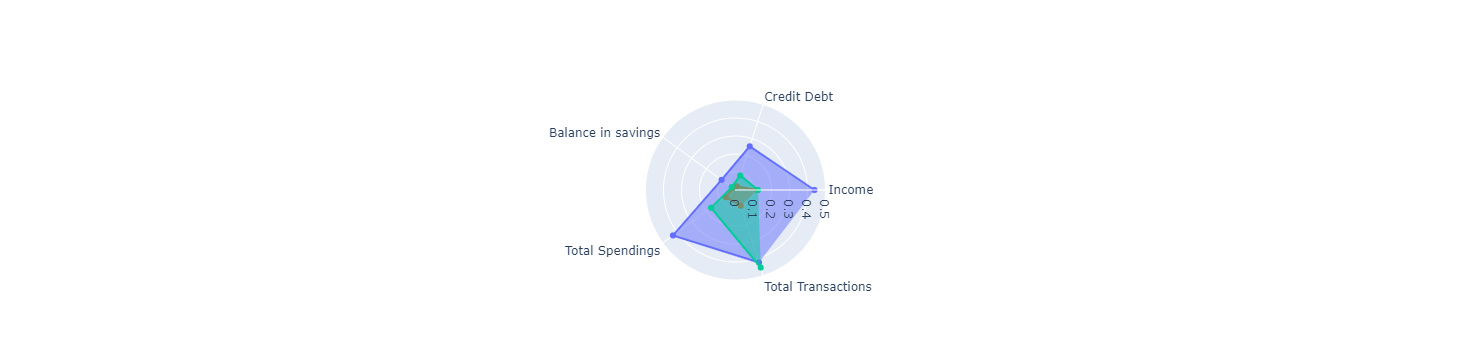

In [24]:
import plotly.graph_objects as go

categories = ['Income','Credit Debt','Balance in savings',
              'Total Spendings', 'Total Transactions']

fig = go.Figure()

fig.add_trace(go.Scatterpolar(
      r=r1,
      theta=categories,
      fill='toself',
      name='Group 1'
))
fig.add_trace(go.Scatterpolar(
      r=r2,
      theta=categories,
      fill='toself',
      name='Group 2'
))

fig.add_trace(go.Scatterpolar(
      r=r3,
      theta=categories,
      fill='toself',
      name='Group 3'
))

fig.update_layout(
  polar=dict(
    radialaxis=dict(
      visible=True,
      range=[0, 0.5]
    )),
  showlegend=False
)

fig.show()

In [25]:
# Plotting explained variance
# how much variance PCA is able to explain
pca = PCA(n_components=2)
pca.fit(data)
exp_var_cumul = np.cumsum(pca.explained_variance_ratio_)

px.area(
    x=range(1, exp_var_cumul.shape[0] + 1),
    y=exp_var_cumul,
    labels={"x": "# Components", "y": "Explained Variance"}


SyntaxError: unexpected EOF while parsing (<ipython-input-25-4ebfb4fe3bda>, line 10)

## Stretch work: clustering evolving over iteration from 1 to 20

In [31]:
%matplotlib inline

In [46]:
def plot_clusters_stretch(X,y_res, ax, iteration, plt_cluster_centers = True):
    X_centroids = []
    Y_centroids = []

    for cluster in set(y_res):
        x = X[y_res == cluster,0]
        y = X[y_res == cluster,1]
        X_centroids.append(np.mean(x))
        Y_centroids.append(np.mean(y))

        ax.scatter(x,
                    y,
                    s=50,
                    marker='o',
                    label=f'cluster {cluster}')

    if plt_cluster_centers:
        ax.scatter(X_centroids,
                    Y_centroids,
                    marker='*',
                    c='red',
                    s=250,
                    label='centroids')
    ax.set_title(f'PCA scatter-bank behavior(iteration: {iteration})')
    ax.set_xlabel('PC-2')
    ax.set_ylabel('PC-1')
    ax.legend(bbox_to_anchor=(0.15, 0.75))
    ax.grid()

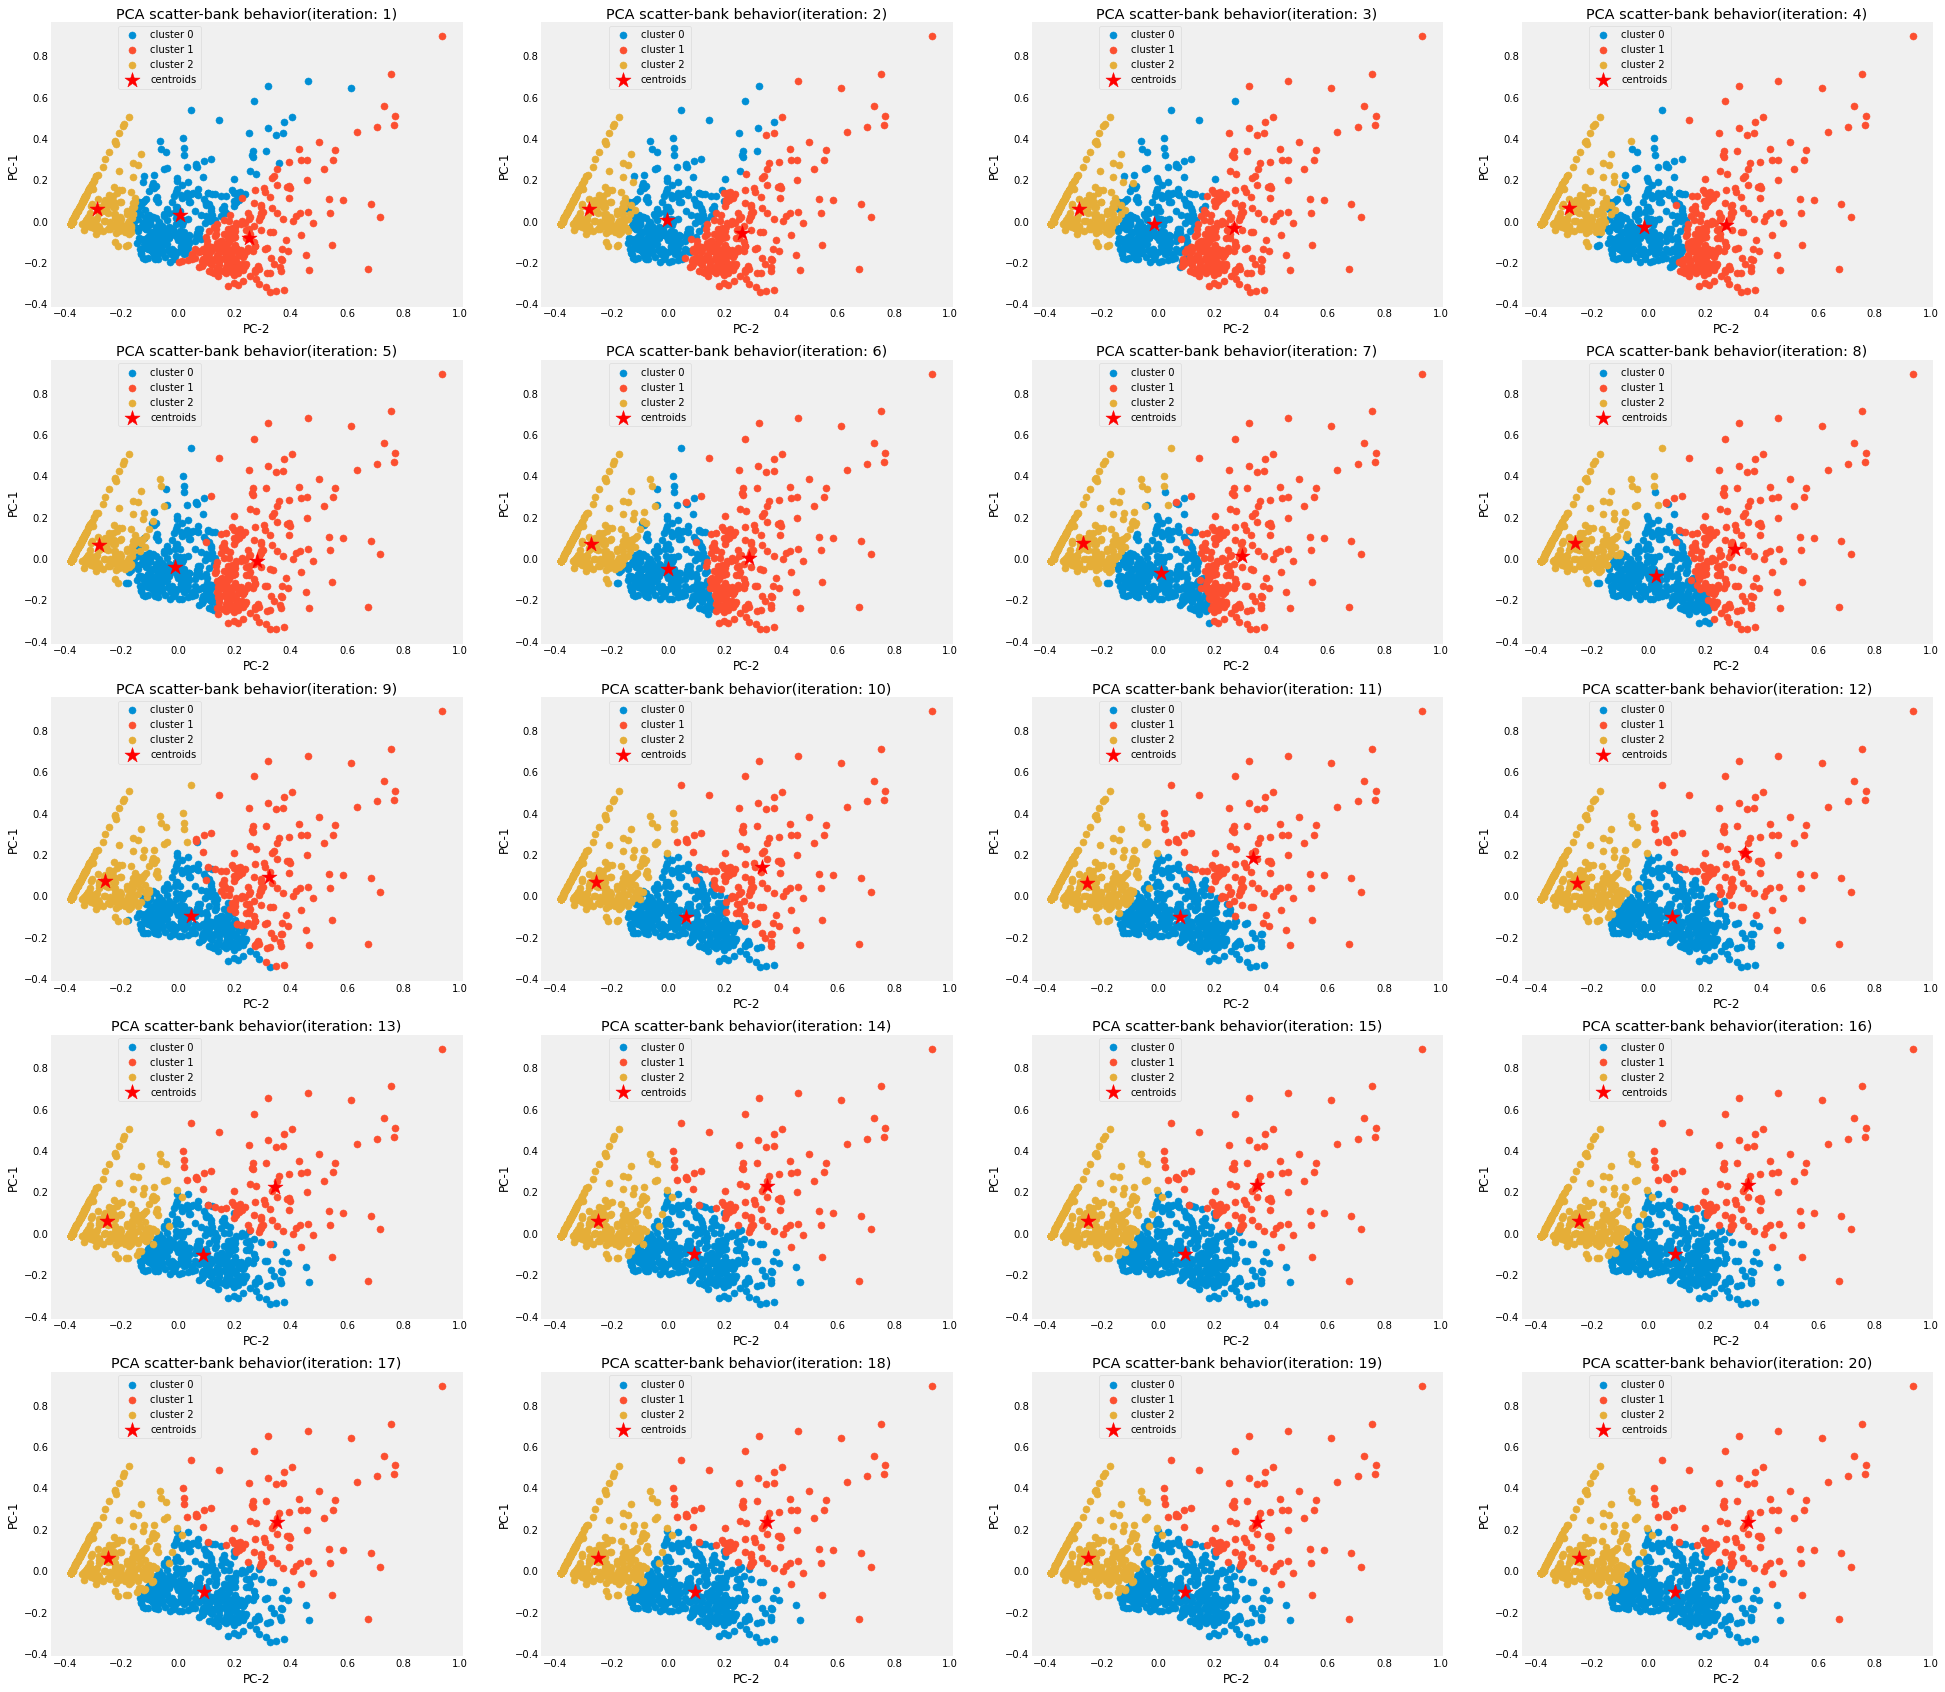

In [50]:
fig, ax = plt.subplots(figsize=(30, 30), nrows=5, ncols=4)
i, j = 0, 0

for iteration in range(1, 21):
    km = KMeans(
        n_clusters=3,
        init='random',
        n_init=1,
        max_iter=iteration,
        random_state=0
    )
    y_km = km.fit_predict(scaled_minmax)
    
    plot_clusters_stretch(data, y_km, ax[i,j], iteration)
    
    if j == 3:
        i += 1
        j = 0
    else:
        j += 1
        
fig.savefig('BankBehavior_iter1-20')